# Exploring Presidential Election Data
This project involves exploratory data analysis of state level presidential election results and sets out to answer the following questions:

* How did each state's vote margin (Democrat vs. Republican) shift between 2012 and 2016? What about shifts between previous presidential elections?
* How did each state's vote margin shift <i>in comparison to the national vote margin</i>?
* Which major factors contributed to vote margin shifts? 
* How did these vote shifts compare to previous elections?

## Transforming State Level Election Data into Dataframes
To obtain presidential election data for 2000-2016, I sourced Dave Leip's Atlas of U.S. Presidential Elections (https://uselectionatlas.org/). This data has been cited as a "preferred source for election results" by statistician and political pundit Nate Silver, as well as many other prominent sources. 

As these election results are contained in disparate sources, some data cleaning and merging is needed to format the data in a way that will be optimal for comparing trends and other data.

In [1]:
import pandas as pd
import numpy as np
import os 

In [2]:
#Get saved data from local folder and store in respective dataframes
df_2016 = pd.read_csv(os.path.expanduser("~/Documents/Data Projects/Analyzing 2016 Election Data/Data Sources/2016_Election_Data.txt"),delimiter='\t')
df_2012 = pd.read_csv(os.path.expanduser("~/Documents/Data Projects/Analyzing 2016 Election Data/Data Sources/2012_Election_Data.txt"),delimiter='\t')
df_2008 = pd.read_csv(os.path.expanduser("~/Documents/Data Projects/Analyzing 2016 Election Data/Data Sources/2008_Election_Data.txt"),delimiter='\t')
df_2004 = pd.read_csv(os.path.expanduser("~/Documents/Data Projects/Analyzing 2016 Election Data/Data Sources/2004_Election_Data.txt"),delimiter='\t')
df_2000 = pd.read_csv(os.path.expanduser("~/Documents/Data Projects/Analyzing 2016 Election Data/Data Sources/2000_Election_Data.txt"),delimiter='\t')

Although the data follows the same general format across all election years, all fields appear as strings. We'll need to convert most of these fields to numeric types so that we can effectively generate calculated fields that we'll explore in more detail later on.

In [3]:
#It will be quicker to recalculate vote percentages using total votes rather than converting 
#all vote percentage columns from a string to a numeric type 
def clean_df(df, candidate_names):
    #Store unique column names (candidates) in the dataset that will be used later on 
    unique_column_names = [item + '.1' for item in candidate_names]
    shared_names = ['State','Total\xa0Vote','%REG']
    shared_names.extend(unique_column_names)
    shared_names.append('Other.1')
    #Keep relevant columns and transform string fields into numeric fields
    cut_df = df[shared_names].copy()
    cut_df['Total Vote'] = cut_df['Total\xa0Vote'].apply(lambda x: int(x.replace(',','')))
    cut_df.drop('Total\xa0Vote', axis=1, inplace=True)
    cut_df['%REG'] = cut_df['%REG'].apply(lambda x: x.replace('%',''))
    cut_df['%REG'] = cut_df['%REG'].apply(pd.to_numeric, errors='coerce')
    for item in unique_column_names:
        cut_df[item] = cut_df[item].apply(lambda x: int(x.replace(',','')))
    cut_df['Other.1'] = cut_df['Other.1'].apply(lambda x: int(x.replace(',','')))
    if len(candidate_names) > 2: #account for data including third party candidates
        third_party = candidate_names[2] + '.1'
        cut_df['Other.1'] = cut_df['Other.1'] + cut_df[third_party]
        cut_df = cut_df.drop(third_party, axis=1)
    #Rename columns and create calculated fields of interest
    final_df = cut_df.copy()
    final_df.columns = ['State','Turnout','D_Votes','R_Votes','Other_Votes','Total_Votes']
    final_df['D_pct'] = round(100*(final_df['D_Votes']/final_df['Total_Votes']),2)
    final_df['R_pct'] = round(100*(final_df['R_Votes']/final_df['Total_Votes']),2)
    final_df['O_pct'] = round(100*(final_df['Other_Votes']/final_df['Total_Votes']),2)
    final_df['R_margin'] = final_df['R_pct'] - final_df['D_pct']
    final_df['R_lean'] = round(final_df['R_margin'] - final_df.loc[51,'R_margin'],2) #subtract state vote margin from national vote margin
    return final_df

We now have a function that takes in the initial messy presidential election dataframe and transforms it into a useful cleaned dataframe consisting of the following fields:
* <b>State</b> 
* <b>Turnout</b> -- voter turnout measured as a percentage (total votes/registered voters)
* <b>D_Votes</b> -- number of votes for the Democratic candidate 
* <b>R_Votes</b> -- number of votes for the Republican candidate 
* <b>Other_Votes</b> -- number of votes for third party candidates and write-ins
* <b>D_pct</b> -- percentage of votes that went to the Democratic candidate
* <b>R_pct</b> -- percentage of votes that went to the Republican candidate
* <b>O_pct</b> -- percentage of votes that went to the third party candidates and write-ins
* <b>R_margin</b> -- percentage of votes that went to the Republican candidate compared to the Democratic candidate
* <b>R_lean</b> -- how the state's Republican margin compared to the nation as a whole (positive number indicates the state voted more Republican than the nation as a whole and negative number indicates it voted more Democratic)

A dataframe containing these fields can now be generated for any election in the Atlas of U.S. Presidential Election's database. We'll stick to storing presidential election data from from 2000 to 2016 in this project and writing the cleaned data to csv files. 


In [4]:
new_df_2016 = clean_df(df_2016, ['Clinton','Trump','Johnson'])
new_df_2012 = clean_df(df_2012, ['Obama','Romney'])
new_df_2008 = clean_df(df_2008, ['Obama','McCain'])
new_df_2004 = clean_df(df_2004, ['Kerry','Bush'])
new_df_2000 = clean_df(df_2000, ['Gore','Bush','Nader'])

election_data = {"2016": new_df_2016, 
                 "2012": new_df_2012, 
                 "2008": new_df_2008, 
                 "2004": new_df_2004, 
                 "2000": new_df_2000}

#Write cleaned datasets to .csv files
for year, dataset in election_data.items():
    dataset.to_csv("~/Documents/Data Projects/Analyzing 2016 Election Data/Data Sources/Cleaned_Election_Data_" + year + ".csv")

#Preview sample dataframe
new_df_2016

State  Turnout   D_Votes   R_Votes  Other_Votes  Total_Votes  \
0          Alabama     63.7    729547   1318255        75570      2123372   
1           Alaska     60.3    116454    163387        38767       318608   
2          Arizona     63.7   1161167   1252401       191089      2604657   
3         Arkansas     64.2    380494    684872        65269      1130635   
4       California     73.3   8753792   4483814      1000287     14237893   
5         Colorado     72.4   1338870   1202484       238893      2780247   
6      Connecticut     69.8    897572    673215        74133      1644920   
7         Delaware     65.7    235603    185127        23084       443814   
8            D. C.     65.0    282830     12723        15715       311268   
9          Florida      NaN   4504975   4617886       379886      9502747   
10         Georgia     76.1   1877963   2089104       174380      4141447   
11          Hawaii     57.2    266891    128847        33199       428937   
12           Idaho     73.7    189765    409055        91613       690433   
13        Illinois     69.7   3090729   2146015       358081      5594825   
14         Indiana     57.1   1033126   1557286       167553      2757965   
15            Iowa     72.1    653669    800983       111379      1566031   
16          Kansas     65.7    427005    671018        96732      1194755   
17        Kentucky     58.2    628854   1202971        92325      1924150   
18       Louisiana     67.1    780154   1178638        70240      2029032   
19           Maine     70.3    357735    335593        54599       747927   
20        Maryland      NaN   1677928    943169       160349      2781446   
21   Massachusetts     73.3   1995196   1090893       238957      3325046   
22        Michigan     64.2   2268839   2279543       276160      4824542   
23       Minnesota     81.3   1367825   1323232       254176      2945233   
24     Mississippi     58.1    485131    700714        25243      1211088   
25        Missouri     67.0   1071068   1594511       162687      2828266   
26         Montana     72.3    177709    279240        44873       501822   
27        Nebraska     69.7    284494    495961        63772       844227   
28          Nevada     67.0    539260    512058        74067      1125385   
29   New Hampshire     73.2    348526    345790        49980       744296   
30      New Jersey     67.3   2148278   1601933       156512      3906723   
31      New Mexico     61.9    385234    319667        93418       798319   
32        New York     61.8   4556142   2819557       346096      7721795   
33  North Carolina     68.8   2189316   2362631       189617      4741564   
34    North Dakota      NaN     93758    216794        33808       344360   
35            Ohio     70.4   2394169   2841006       301372      5536547   
36        Oklahoma     67.3    420375    949136        83481      1452992   
37          Oregon     78.4   1002106    782403       216827      2001336   
38    Pennsylvania     70.7   2926441   2970733       269555      6166729   
39    Rhode Island     60.2    252525    180543        31076       464144   
40  South Carolina     67.2    855373   1155389        92265      2103027   
41    South Dakota     62.2    117458    227721        24914       370093   
42       Tennessee     61.0    870695   1522925       114407      2508027   
43           Texas     59.6   3877868   4685047       430251      8993166   
44            Utah     72.5    310676    515231       317694      1143601   
45         Vermont     66.8    178573     95369        41125       315067   
46        Virginia     71.1   1981473   1769443       231836      3982752   
47      Washington     77.7   1742718   1221747       352531      3316996   
48   West Virginia     56.6    188794    489371        43068       721233   
49       Wisconsin     80.2   1382536   1405284       188330      2976150   
50         Wyoming     92.0     55973    174419        25457       255849   
51       

## Plotting State Margin and Partisan Lean Shift 

A popular topic discussed among political analysts is the trend in partisan shift among various swing states. Many political analysts use demographic data such as income, race, and education to predict how a certain state is trending (more Democratic or more Republican). Though state vote margins between elections describe how a state's vote shifted, a more accurate measure of whether a state is trending blue (Democratic) or red (Republican) is to compare each state's shift to the national vote shift in order to determine partisan lean. Here we'll use matplotlib to visualize both margin shift and partisan lean shift for all 50 states + DC between any two election years already loaded into dataframes. 

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches

In [6]:
def visualize_shifts(df1, df2, year1, year2, measure, highlighted=None):   
    """Takes election data from two years and outputs a visual measuring either the shift in each state's vote margin
    or the shift in each state's partisan lean from one election to a subsequent one.
    ----Parameters---
    df1 -- election dataframe which is the most recent year
    df2 -- election dataframe for a year prior to df1
    year1 -- year which df1 is representing, as a string
    year2 -- year which df2 is representing, as a string
    measure -- takes in a string that is either 'margin' or 'lean' -- if 'margin', the visual will display 
    shifts as each state's vote margin shift -- if 'lean' the visual will display shifts as each state's vote margin 
    shift in comparison to the national shift
    highlighted - takes a state list that highlights these particular states in the visual"""
    #Combine election dataframes
    combined_df = df1.merge(df2[['State','R_margin','R_lean']], on='State', how='left',suffixes=('_'+year1,'_'+year2))
    #Set parameters based on measure
    if measure == 'margin':
        title = "How Did Each State's Vote Margin Shift from " + year2 + " to " + year1 + "?"
        subtitle = "Visualizing the shift of each state's presidential vote margin (Democrat vs. Republican) from " + year2 + " to " + year1
        x_label = "Presidential Vote Margin"
        sorted_df = combined_df.sort_values(by='R_lean_'+ year1, ascending=False).reset_index(drop=True)
        y_legend = 49.83
        y_max = 53
    elif measure == 'lean':
        title = "How Did Each State's Partisan Lean Shift from " + year2 + " to " + year1 + "?"
        subtitle = "Visualizing the shift of each state's partisan lean (margin compared to national vote) from " + year2 + " to " + year1
        x_label = "Partisan Lean"
        cut_df = combined_df.loc[:50,:] #remove national vote
        sorted_df = cut_df.sort_values(by='R_lean_'+year1, ascending=False).reset_index(drop=True)
        y_legend = 49.12
        y_max = 52
    #Format the chart 
    plt.style.use('fivethirtyeight') #use fivethirtyeight's color scheme
    fig,ax = plt.subplots(figsize=(100,115))
    ax.set_ylim(-1.5, y_max)
    ax.set_xlim(-50, 50) 
    ax.set_xticks(np.arange(-40, 50, 10))
    for i in np.arange(-40, 50, 10):
        if i < 0:
            string = 'D+' + str(-i)
        elif i == 0:
            string = 'EVEN'
        else:
            string = 'R+' + str(i)
        plt.text(i, -1.2, string, fontname='Arial',fontsize=68, ha='center', alpha=0.8)
        plt.text(i, y_max-0.6, string, fontname='Arial',fontsize=68, ha='center', alpha=0.8)
    ax.set_xlabel(x_label, fontname='Verdana', fontsize=95, alpha=0.8)
    ax.text(-50, y_max + 1.2, title, fontname='Verdana', fontsize=120, weight='bold')
    ax.text(-50, y_max + 0.3, subtitle, fontname='Verdana',fontsize=80)
    ax.grid(linewidth=2)
    ax = plt.gca()
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().axes.xaxis.set_ticklabels([])
    ax.vlines(x=0, ymin=-0.7, ymax=y_max-0.7, zorder=2, alpha=0.3)
    rect = plt.Rectangle((-50, -2), 50, y_max + 2,edgecolor='b',facecolor='b',alpha=0.07)
    plt.gca().add_patch(rect)
    rect = plt.Rectangle((0, -2), 50, y_max + 2, edgecolor='r', facecolor='r', alpha=0.07)
    plt.gca().add_patch(rect)
    #Iterate over each state to plot it's own respective shift 
    for i, state in sorted_df['State'].iteritems():
        visible = True 
        if measure == 'margin':
            x1 = sorted_df.iat[i,9]
            x2 = sorted_df.iat[i,11]
        elif measure == 'lean':
            x1 = sorted_df.iat[i,10]
            x2 = sorted_df.iat[i,12]
        #Check for national vote
        plot_alpha = 0.95
        text_alpha = 0.95
        text = state
        weight = 'normal'
        if state == 'Total':
            plot_alpha = 0.6
            text = 'National Vote'
            weight = 'bold'
        elif highlighted is not None:
            if state not in highlighted:
                plot_alpha = 0.2
                text_alpha = 0.2
        #Check for states out of chart range
        if x1 <= -50.0 and x2 <=-50.0:
            x1 = -50.5
            x2 = -50.5
            text = '*' + state + ' too far out of range to show'
            x_position = -20.0
            visible = False
            alignment = 'right'
        elif x1 >= 50.0 and x2 >=50.0:
            x1 = 50.0
            x2 = 50.0
            text = '*' + state + ' too far out of range to show'
            x_position = 50.0
            alignment = 'left'
            visible = False
        #Determine direction and color of line and arrow 
        if x1 > x2:
            dx = 0.18
            c='r'
            alignment = 'right'
            x_position = x1 - 0.8
            year = year1
        else:
            dx = -0.18
            c='b'
            alignment = 'left'
            x_position = x1 + 0.8
            year = year2
        #Plot state line and arrow
        ax.plot([x1,x2],[i,i], c=c, alpha=plot_alpha, linewidth=12.0)
        ax.text(x_position, i + 0.2, text, fontname='Arial', fontsize=65, alpha=text_alpha, style='italic', ha=alignment, weight=weight)
        ax.arrow(x=x1, y=i, dx=dx, dy=0.0, shape='full', alpha=plot_alpha, length_includes_head=True, head_width=0.5, color=c,zorder=1)

Let's start by analyzing how each state's vote margin shifted from 2012 to 2016.

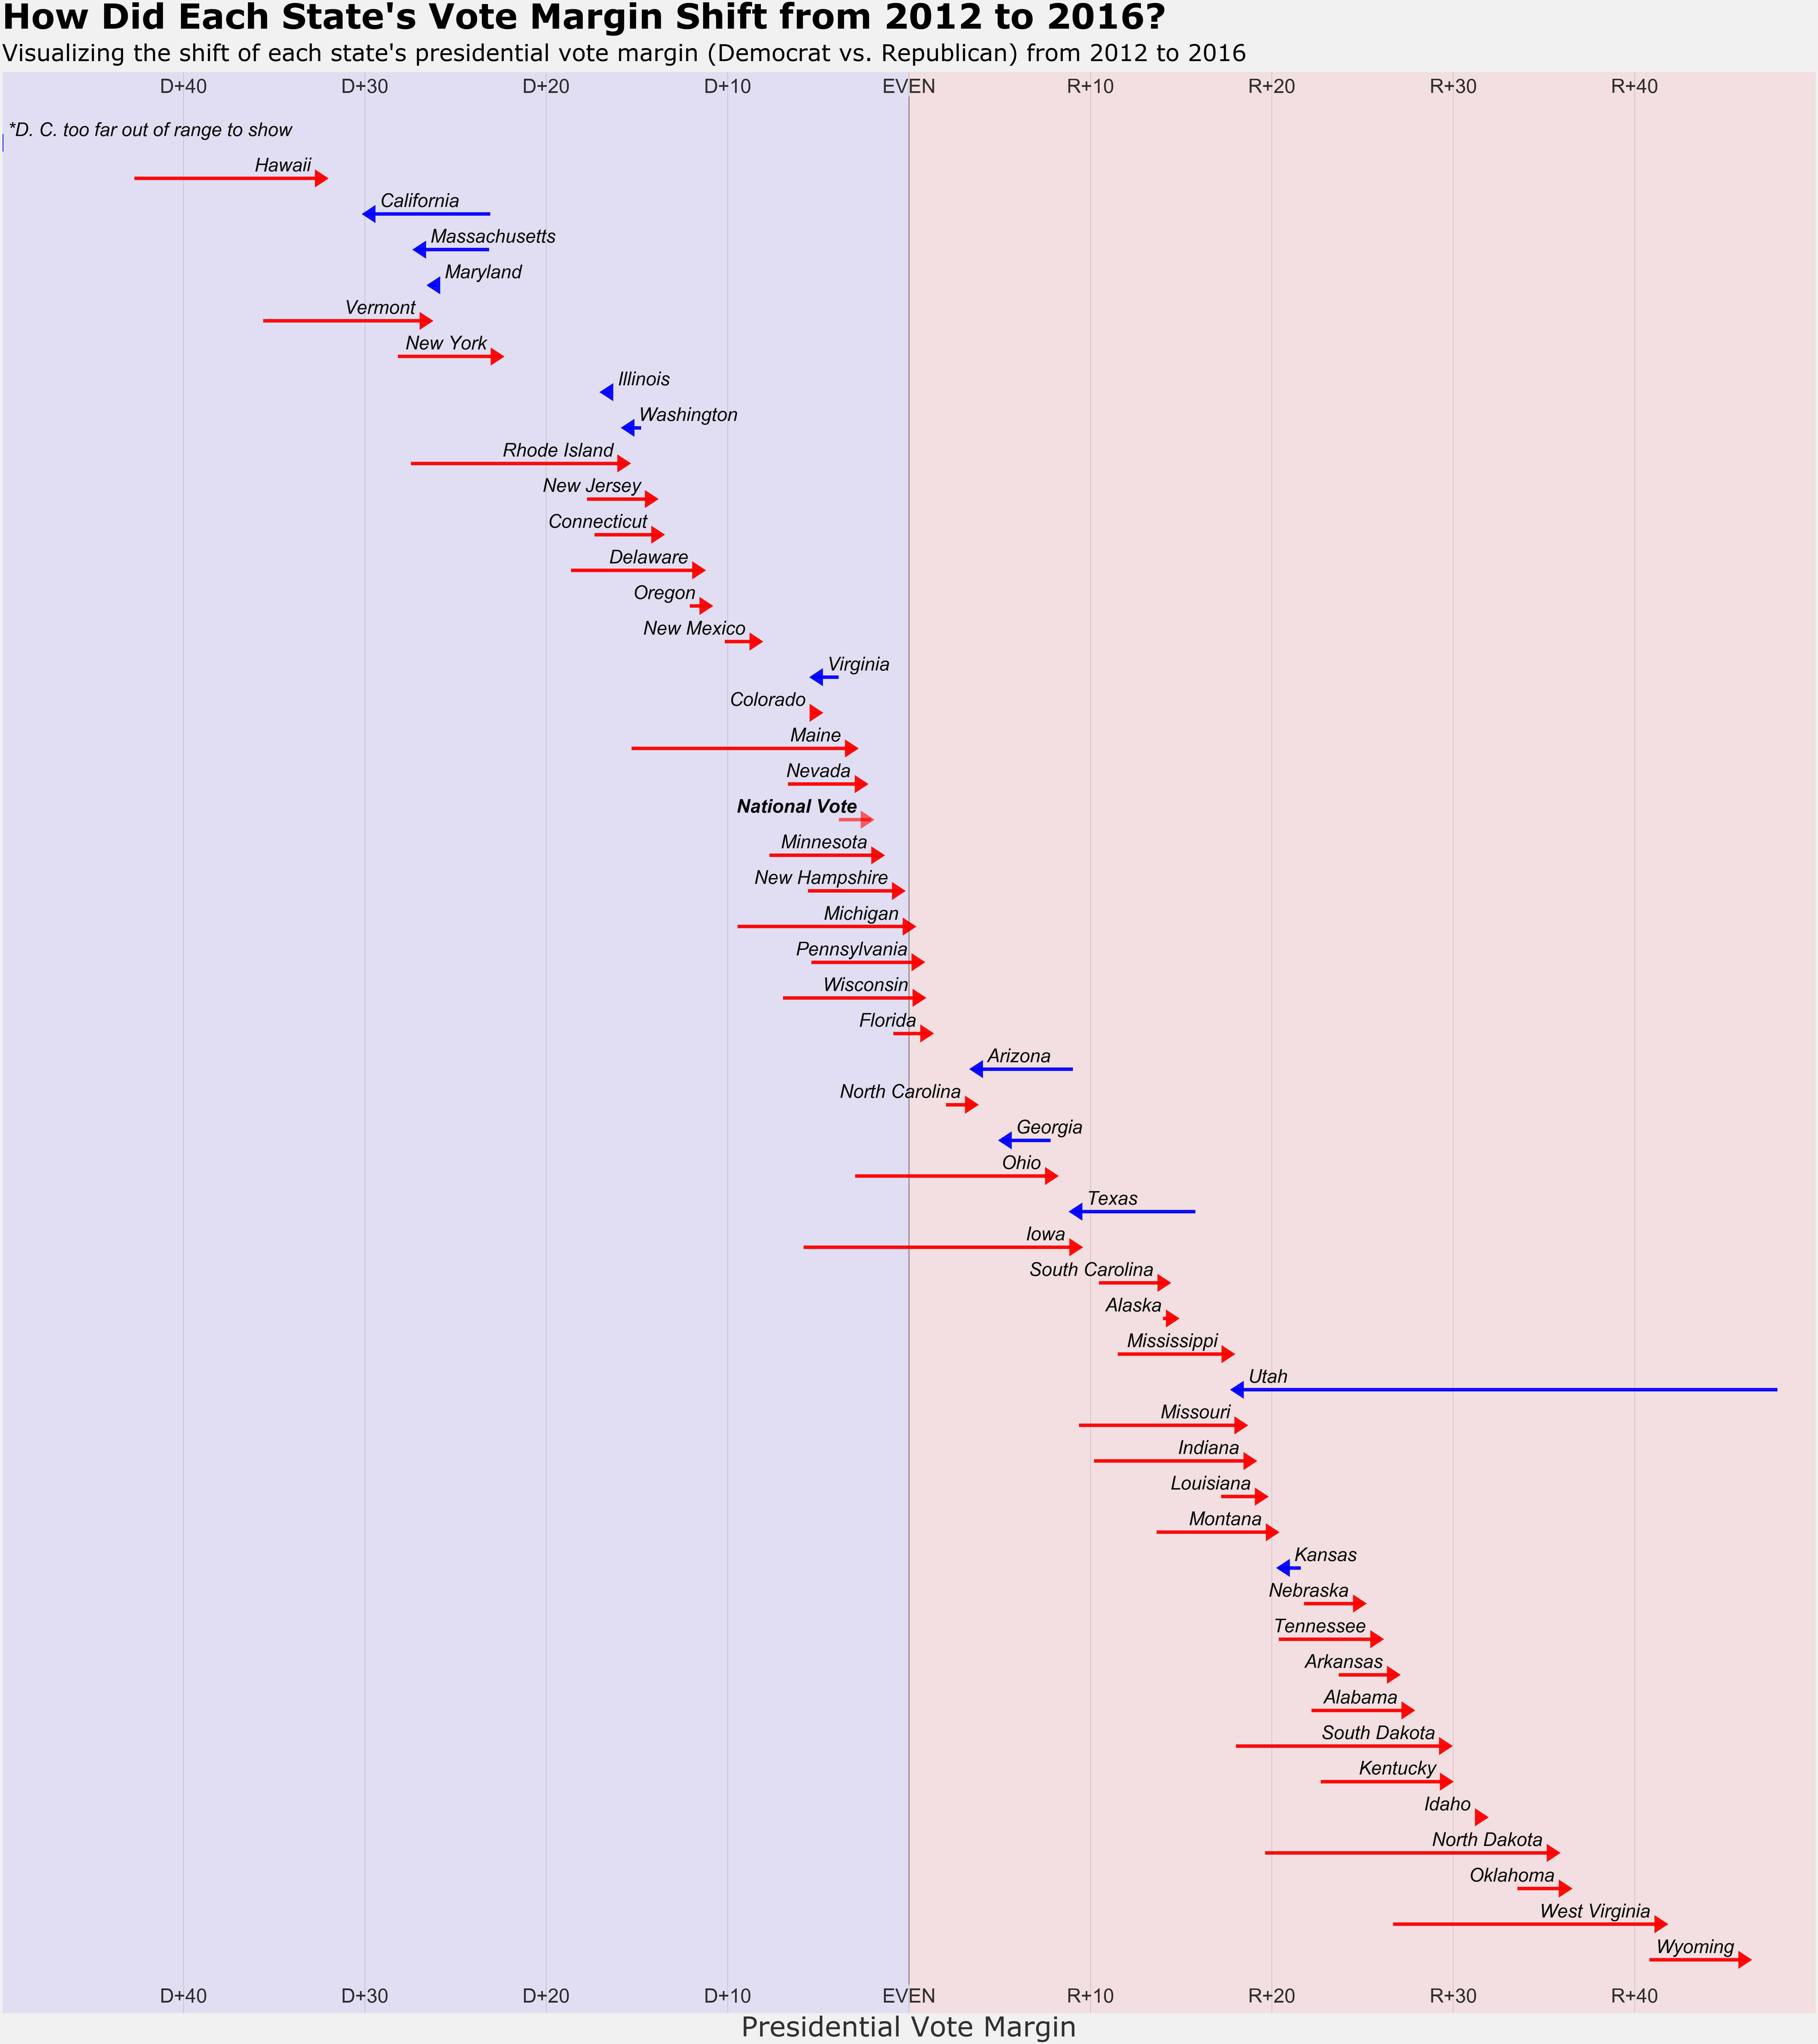

In [7]:
visualize_shifts(new_df_2016, new_df_2012, '2016', '2012', 'margin')

Analysis:
* It appears that only a handful of states swung left while a large number of states swung right.
* From a first glance it appears that states in the Rust Belt, Midwest, and New England had the most drastic swings to the right. These regions share similar traits in regards to demographics and population growth.
* Utah swung most drastically to the left. However, this is deceiving as third party candidate Evan McMullin (ideologically conservative) took a large chunk of Republican voters which drastically shrunk the Democrat vs. Republican vote margin.
* Though a large portion of states show a drastic shift to the right, the national vote did not really shift much from 2012 to 2016. California and Texas, the two most populated states in the US, both shifted significantly to the left. These shifts could explain how the national vote shift was offset by a large increase of Democratic votes coming from these two states. 

Now let's visualize how each state's vote margin shifted <i>in comparison</i> to the national vote.

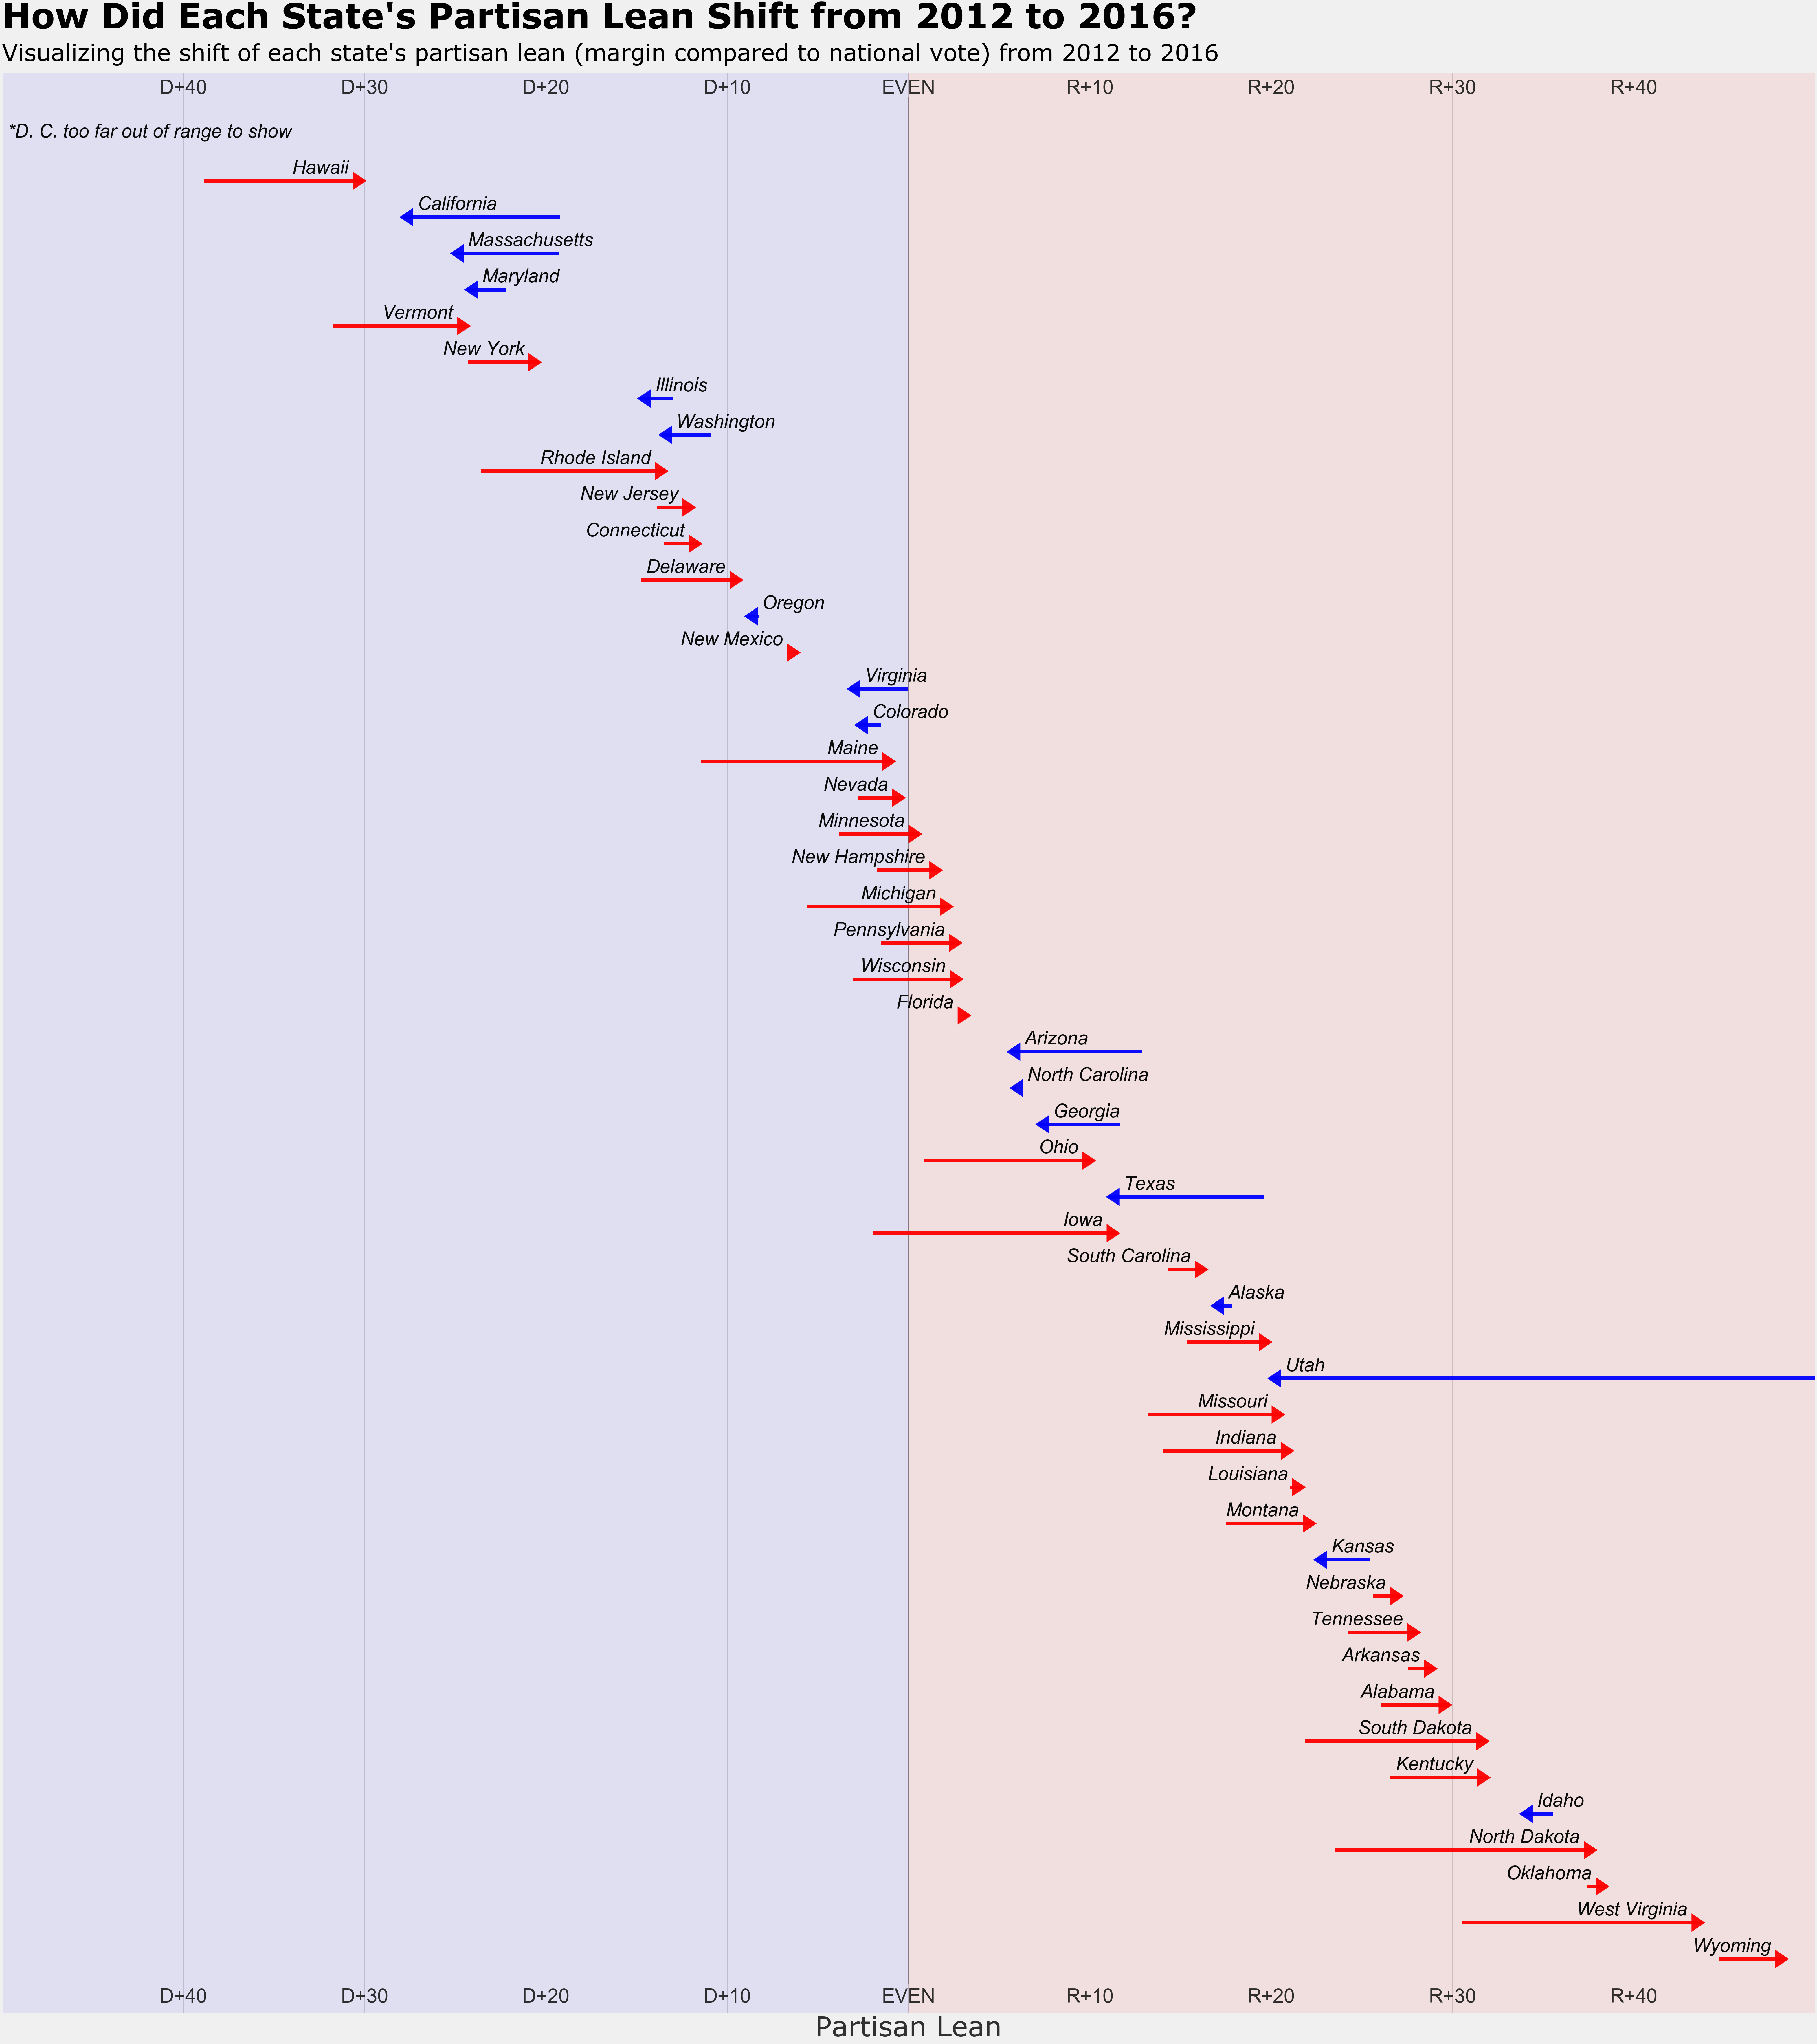

In [8]:
visualize_shifts(new_df_2016, new_df_2012, '2016', '2012', 'lean')

This chart provides a better representation of each state's shift in <i>partisan bias</i> from 2012 to 2016.

Analysis:
* 6 states went from having a Democratic partisan lean in 2012 to having a Republican one in 2016, including the 3 key swing states that handed Trump the election: Wisconsin, Michigan, and Pennsylvania.

## Investigating Factors in Vote Shifts

Here we'll dive deeper into the data further to uncover any interesting patterns and correlations in vote margin shifts between 2012 and 2016. 

As we see above, the states which swung most drastically to the right in 2016 were those located in the Rust Belt, Midwest, and New England. This is presumably due to a rightward shift among rural, white voters. It could also be due to economic decline and a lack of population growth. 

Let's investigate the following factors and see what we uncover:
* Population growth
* White population %
* Rural popuation %  

<b>Note</b>: We won't be looking at economic data at this time, as obtaining all (free) state economic data from 2012 to 2016 would be extremely tedious. However, this could be explored at another time in the future.

### Population Growth

First, lets look into change in total votes, as it is a pretty good indicator of population growth. We'll merge data from the 2012 and 2016 dataframes into a single one so that we can calculate the vote increase percentage for each state and plot it against the Republican vote margin shift. 

In [9]:
merged_df = new_df_2016[['State','Total_Votes','R_margin']].merge(new_df_2012[['State','Total_Votes','R_margin']],on='State',how='left',suffixes=('_2016','_2012'))
merged_df['% Change in Total Votes'] = round(100*((merged_df['Total_Votes_2016'] - merged_df['Total_Votes_2012'])/merged_df['Total_Votes_2012']),2)
merged_df['Shift in R Vote Margin'] = merged_df['R_margin_2016'] - merged_df['R_margin_2012']
#Remove Utah as it is an outlier due to Evan McMullin siphoning off a large number of Republican votes -- also remove national vote 
election_df = merged_df[(merged_df.State != 'Utah') & (merged_df.State != 'Total')] 
election_df #preview dataframe

State  Total_Votes_2016  R_margin_2016  Total_Votes_2012  \
0          Alabama           2123372          27.72           2074338   
1           Alaska            318608          14.73            300495   
2          Arizona           2604657           3.50           2306559   
3         Arkansas           1130635          26.92           1069468   
4       California          14237893         -29.99          13055815   
5         Colorado           2780247          -4.91           2571846   
6      Connecticut           1644920         -13.64           1558993   
7         Delaware            443814         -11.38            413921   
8            D. C.            311268         -86.77            293764   
9          Florida           9502747           1.19           8492175   
10         Georgia           4141447           5.09           3908369   
11          Hawaii            428937         -32.18            434697   
12           Idaho            690433          31.77            656742   
13        Illinois           5594825         -16.88           5251432   
14         Indiana           2757965          19.01           2633143   
15            Iowa           1566031           9.41           1582180   
16          Kansas           1194755          20.42           1157532   
17        Kentucky           1924150          29.84           1798048   
18       Louisiana           2029032          19.64           1994065   
19           Maine            747927          -2.96            713180   
20        Maryland           2781446         -26.42           2707327   
21   Massachusetts           3325046         -27.20           3167767   
22        Michigan           4824542           0.22           4745316   
23       Minnesota           2945233          -1.51           2936561   
24     Mississippi           1211088          17.80           1285584   
25        Missouri           2828266          18.51           2763689   
26         Montana            501822          20.24            484484   
27        Nebraska            844227          25.05            794379   
28          Nevada           1125385          -2.42           1014918   
29   New Hampshire            744296          -0.37            710972   
30      New Jersey           3906723         -13.99           3651140   
31      New Mexico            798319          -8.22            783757   
32        New York           7721795         -22.49           7081536   
33  North Carolina           4741564           3.66           4505372   
34    North Dakota            344360          35.73            322627   
35            Ohio           5536547           8.07           5590934   
36        Oklahoma           1452992          36.39           1334872   
37          Oregon           2001336         -10.98           1789270   
38    Pennsylvania           6166729           0.71           5755620   
39    Rhode Island            464144         -15.51            446049   
40  South Carolina           2103027          14.27           1964118   
41    South Dakota            370093          29.79            363815   
42       Tennessee           2508027          26.00           2460904   
43           Texas           8993166           8.98           7999657   
45         Vermont            315067         -26.41            299290   
46        Virginia           3982752          -5.32           3854489   
47      Washington           3316996         -15.71           3145958   
48   West Virginia            721233          41.67            672119   
49       Wisconsin           2976150           0.77           3068434   
50         Wyoming            255849          46.29            249061   

    R_margin_2012  % Change in Total Votes  Shift in R Vote Margin  
0           22.19                     2.36                    5.53  
1           13.99                     6.03                    0.74  
2            9.03                    12.92                   -5.53  
3           2

Let's use seaborn to plot vote increase vs. partisan shift to see how total votes cast (and presumably population growth) influenced the shift in partisan bias. 

In [10]:
#Creates a function used for formatting all scatter plots
def format_scatter():
    #Add red-blue shading
    rect = plt.Rectangle((-10, -7.5), 10, 22.5,edgecolor='b',facecolor='b',alpha=0.07)
    plt.gca().add_patch(rect)
    rect = plt.Rectangle((0, -7.5), 17.5, 22.5, edgecolor='r', facecolor='r', alpha=0.07)
    plt.gca().add_patch(rect)    

-0.43579216986459207

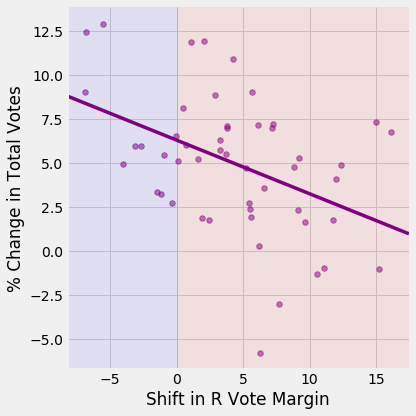

In [11]:
import seaborn as sns

sns.lmplot(x='Shift in R Vote Margin', y='% Change in Total Votes', data=election_df, fit_reg=True, size=6, aspect=1,
           scatter_kws={"s": 30, "color":"purple", "alpha": 0.5}, line_kws={"lw": 3.5, "color":"purple"}, ci=None)
format_scatter()

election_df['Shift in R Vote Margin'].corr(election_df['% Change in Total Votes']) 

Interestingly enough, there seems to be a moderate negative correlation (-0.44) between vote increase and increase in Republican vote margin/bias, or a positive correlation (0.44) between vote increase and increase in Democractic vote margin/bias. 

### White Population %
A major talking point after the election involved Trump's appeal to the white working class (https://www.nytimes.com/2016/11/10/upshot/why-trump-won-working-class-whites.html). Let's look at the increase in Republican vote margin/bias in comparison to the white population slice of each state. We'll use recent demographic estimates (https://www.kff.org/other/state-indicator/distribution-by-raceethnicity/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D#notes) to factor in white population percentage into our existing dataframe. 

In [12]:
#Get demographic data
demographic_df = pd.read_csv(os.path.expanduser("~/Documents/Data Projects/Analyzing 2016 Election Data/Data Sources/demographic_data.txt"),delimiter='\t')
clean_demo_df = demographic_df[['Location','White']]
clean_demo_df.columns = ['State','White Population %']
clean_demo_df.at[9,'State'] = 'D. C.' #match DC's format in other dataframes
race_df = election_df.merge(clean_demo_df, on='State', how='left')
race_df #preview dataframe

State  Total_Votes_2016  R_margin_2016  Total_Votes_2012  \
0          Alabama           2123372          27.72           2074338   
1           Alaska            318608          14.73            300495   
2          Arizona           2604657           3.50           2306559   
3         Arkansas           1130635          26.92           1069468   
4       California          14237893         -29.99          13055815   
5         Colorado           2780247          -4.91           2571846   
6      Connecticut           1644920         -13.64           1558993   
7         Delaware            443814         -11.38            413921   
8            D. C.            311268         -86.77            293764   
9          Florida           9502747           1.19           8492175   
10         Georgia           4141447           5.09           3908369   
11          Hawaii            428937         -32.18            434697   
12           Idaho            690433          31.77            656742   
13        Illinois           5594825         -16.88           5251432   
14         Indiana           2757965          19.01           2633143   
15            Iowa           1566031           9.41           1582180   
16          Kansas           1194755          20.42           1157532   
17        Kentucky           1924150          29.84           1798048   
18       Louisiana           2029032          19.64           1994065   
19           Maine            747927          -2.96            713180   
20        Maryland           2781446         -26.42           2707327   
21   Massachusetts           3325046         -27.20           3167767   
22        Michigan           4824542           0.22           4745316   
23       Minnesota           2945233          -1.51           2936561   
24     Mississippi           1211088          17.80           1285584   
25        Missouri           2828266          18.51           2763689   
26         Montana            501822          20.24            484484   
27        Nebraska            844227          25.05            794379   
28          Nevada           1125385          -2.42           1014918   
29   New Hampshire            744296          -0.37            710972   
30      New Jersey           3906723         -13.99           3651140   
31      New Mexico            798319          -8.22            783757   
32        New York           7721795         -22.49           7081536   
33  North Carolina           4741564           3.66           4505372   
34    North Dakota            344360          35.73            322627   
35            Ohio           5536547           8.07           5590934   
36        Oklahoma           1452992          36.39           1334872   
37          Oregon           2001336         -10.98           1789270   
38    Pennsylvania           6166729           0.71           5755620   
39    Rhode Island            464144         -15.51            446049   
40  South Carolina           2103027          14.27           1964118   
41    South Dakota            370093          29.79            363815   
42       Tennessee           2508027          26.00           2460904   
43           Texas           8993166           8.98           7999657   
44         Vermont            315067         -26.41            299290   
45        Virginia           3982752          -5.32           3854489   
46      Washington           3316996         -15.71           3145958   
47   West Virginia            721233          41.67            672119   
48       Wisconsin           2976150           0.77           3068434   
49         Wyoming            255849          46.29            249061   

    R_margin_2012  % Change in Total Votes  Shift in R Vote Margin  \
0           22.19                     2.36                    5.53   
1           13.99                     6.03                    0.74   
2            9.03                    12.92                   -5.53   
3        

Let's now plot white population vs. partisan shift to see how a state's white population percentage influenced the shift in partisan bias.

0.54838710371978994

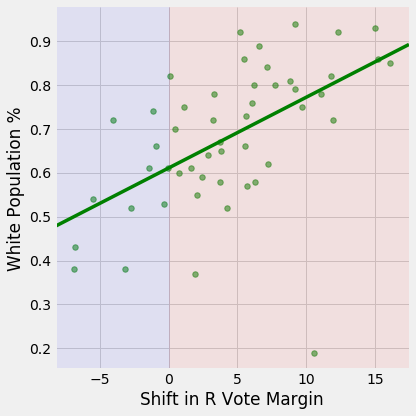

In [13]:
#shift_demo_df = election_df[['State','Vote_Increase_pct','R_margin_shift','R_margin_2016','R_margin_2012']].merge(merged_df[['State','white_pct','norm_rural_pct','white_rural_factor']], on='State', how='left')
sns.lmplot(x='Shift in R Vote Margin', y='White Population %', data=race_df, fit_reg=True, size=6, aspect=1,
           scatter_kws={"s": 30, "color":"green", "alpha": 0.5}, line_kws={"lw": 3.5, "color":"green"}, ci=None)
format_scatter()

race_df['Shift in R Vote Margin'].corr(race_df['White Population %']) 

Shift in Republican vote margin is moderately positively correlated (0.55) with percentage of white residents within a state.

### Rural Population %

Another major talking point after the 2016 election was the growing rural-urban divide in voting patterns (https://www.washingtonpost.com/graphics/politics/2016-election/urban-rural-vote-swing/). We'll use 2010 census data (https://www.census.gov/geo/reference/ua/urban-rural-2010.html) to factor in rural population percentage to our existing dataframe and plot the correlation with shift in Republican vote margin.




In [14]:
#Get rural-urban data
pop_df = pd.read_csv(os.path.expanduser("~/Documents/Data Projects/Analyzing 2016 Election Data/Data Sources/pop_description_by_state.txt"),delimiter='\t')
clean_pop_df = pop_df[['STATENAME','POPPCT_RURAL']]
clean_pop_df.columns = ['State','rural_pct']
clean_pop_df.at[8,'State'] = 'D. C.' #match DC's format in other dataframes
rural_df = race_df.merge(clean_pop_df, on='State', how='left')
rural_df['Rural Population %'] = round(rural_df['rural_pct'] / 100, 2) #normalize rural_pct for consistency
rural_df #preview dataframe

State  Total_Votes_2016  R_margin_2016  Total_Votes_2012  \
0          Alabama           2123372          27.72           2074338   
1           Alaska            318608          14.73            300495   
2          Arizona           2604657           3.50           2306559   
3         Arkansas           1130635          26.92           1069468   
4       California          14237893         -29.99          13055815   
5         Colorado           2780247          -4.91           2571846   
6      Connecticut           1644920         -13.64           1558993   
7         Delaware            443814         -11.38            413921   
8            D. C.            311268         -86.77            293764   
9          Florida           9502747           1.19           8492175   
10         Georgia           4141447           5.09           3908369   
11          Hawaii            428937         -32.18            434697   
12           Idaho            690433          31.77            656742   
13        Illinois           5594825         -16.88           5251432   
14         Indiana           2757965          19.01           2633143   
15            Iowa           1566031           9.41           1582180   
16          Kansas           1194755          20.42           1157532   
17        Kentucky           1924150          29.84           1798048   
18       Louisiana           2029032          19.64           1994065   
19           Maine            747927          -2.96            713180   
20        Maryland           2781446         -26.42           2707327   
21   Massachusetts           3325046         -27.20           3167767   
22        Michigan           4824542           0.22           4745316   
23       Minnesota           2945233          -1.51           2936561   
24     Mississippi           1211088          17.80           1285584   
25        Missouri           2828266          18.51           2763689   
26         Montana            501822          20.24            484484   
27        Nebraska            844227          25.05            794379   
28          Nevada           1125385          -2.42           1014918   
29   New Hampshire            744296          -0.37            710972   
30      New Jersey           3906723         -13.99           3651140   
31      New Mexico            798319          -8.22            783757   
32        New York           7721795         -22.49           7081536   
33  North Carolina           4741564           3.66           4505372   
34    North Dakota            344360          35.73            322627   
35            Ohio           5536547           8.07           5590934   
36        Oklahoma           1452992          36.39           1334872   
37          Oregon           2001336         -10.98           1789270   
38    Pennsylvania           6166729           0.71           5755620   
39    Rhode Island            464144         -15.51            446049   
40  South Carolina           2103027          14.27           1964118   
41    South Dakota            370093          29.79            363815   
42       Tennessee           2508027          26.00           2460904   
43           Texas           8993166           8.98           7999657   
44         Vermont            315067         -26.41            299290   
45        Virginia           3982752          -5.32           3854489   
46      Washington           3316996         -15.71           3145958   
47   West Virginia            721233          41.67            672119   
48       Wisconsin           2976150           0.77           3068434   
49         Wyoming            255849          46.29            249061   

    R_margin_2012  % Change in Total Votes  Shift in R Vote Margin  \
0           22.19                     2.36                    5.53   
1           13.99                     6.03                    0.74   
2            9.03                    12.92                   -5.53   
3        

0.51944379914654049

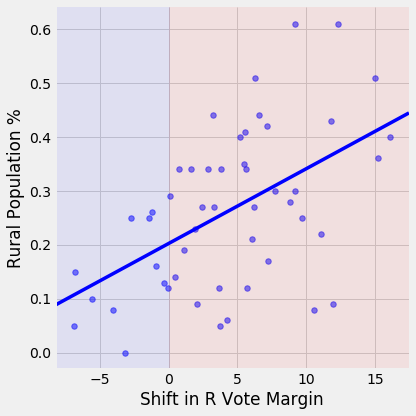

In [15]:
sns.lmplot(x='Shift in R Vote Margin', y='Rural Population %', data=rural_df, fit_reg=True, size=6, aspect=1,
           scatter_kws={"s": 30, "color":"blue", "alpha": 0.5}, line_kws={"lw": 3.5, "color":"blue"}, ci=None)
format_scatter()

rural_df['Shift in R Vote Margin'].corr(rural_df['Rural Population %']) 

Shift in Republican vote margin is moderately correlated (0.52) with states containing a larger rural population.

### Investigation Summary

We found the following factors were all moderately correlated with shift in Republican vote margin:
* Population growth (-0.44)
* White population % (0.55)
* Rural population % (0.52) 

Though population growth presumably played a significant factor in the 2016 election, majority white and rural states showed the most significant correlation with shifts in Republican vote margin. This data backs the notion that both the rural-urban divide and white working class votes played a huge role in the 2016 election. 

## Visualizing Shifts among White, Rural States in Previous Elections

We can use our existing data and functions to easily focus on the 10 most white, rural states in the US and compare their shift in the 2016 election to previous presidential elections. 

Let's start by calculating a "white_rural_score" that just combines and averages each state's white and rural percentage score. We'll use the top 10 scores to find the 10 most white, rural states. 

In [16]:
rural_df['white_rural_factor'] = ((rural_df['Rural Population %'] + rural_df['White Population %'])/2)
#Sort dataframe by 10 most white and rural states
white_rural_df = rural_df.sort_values(by='white_rural_factor',ascending=False)[:10]
white_rural_df = white_rural_df.reset_index(drop=True)
highlighted_list = white_rural_df['State'].tolist()
white_rural_df #preview dataframe

State  Total_Votes_2016  R_margin_2016  Total_Votes_2012  \
0        Vermont            315067         -26.41            299290   
1          Maine            747927          -2.96            713180   
2  West Virginia            721233          41.67            672119   
3        Montana            501822          20.24            484484   
4  New Hampshire            744296          -0.37            710972   
5       Kentucky           1924150          29.84           1798048   
6   South Dakota            370093          29.79            363815   
7   North Dakota            344360          35.73            322627   
8           Iowa           1566031           9.41           1582180   
9        Wyoming            255849          46.29            249061   

   R_margin_2012  % Change in Total Votes  Shift in R Vote Margin  \
0         -35.60                     5.27                    9.19   
1         -15.29                     4.87                   12.33   
2          26.69                     7.31                   14.98   
3          13.64                     3.58                    6.60   
4          -5.58                     4.69                    5.21   
5          22.69                     7.01                    7.15   
6          18.02                     1.73                   11.77   
7          19.63                     6.74                   16.10   
8          -5.81                    -1.02                   15.22   
9          40.82                     2.73                    5.47   

   White Population %  rural_pct  Rural Population %  white_rural_factor  
0                0.94      61.10                0.61               0.775  
1                0.92      61.34                0.61               0.765  
2                0.93      51.28                0.51               0.720  
3                0.89      44.11                0.44               0.665  
4                0.92      39.70                0.40               0.660  
5                0.84      41.62                0.42               0.630  
6                0.82      43.35                0.43               0.625  
7                0.85      40.10                0.40               0.625  
8                0.86      35.98                0.36               0.610  
9                0.86      35.24                0.35               0.605

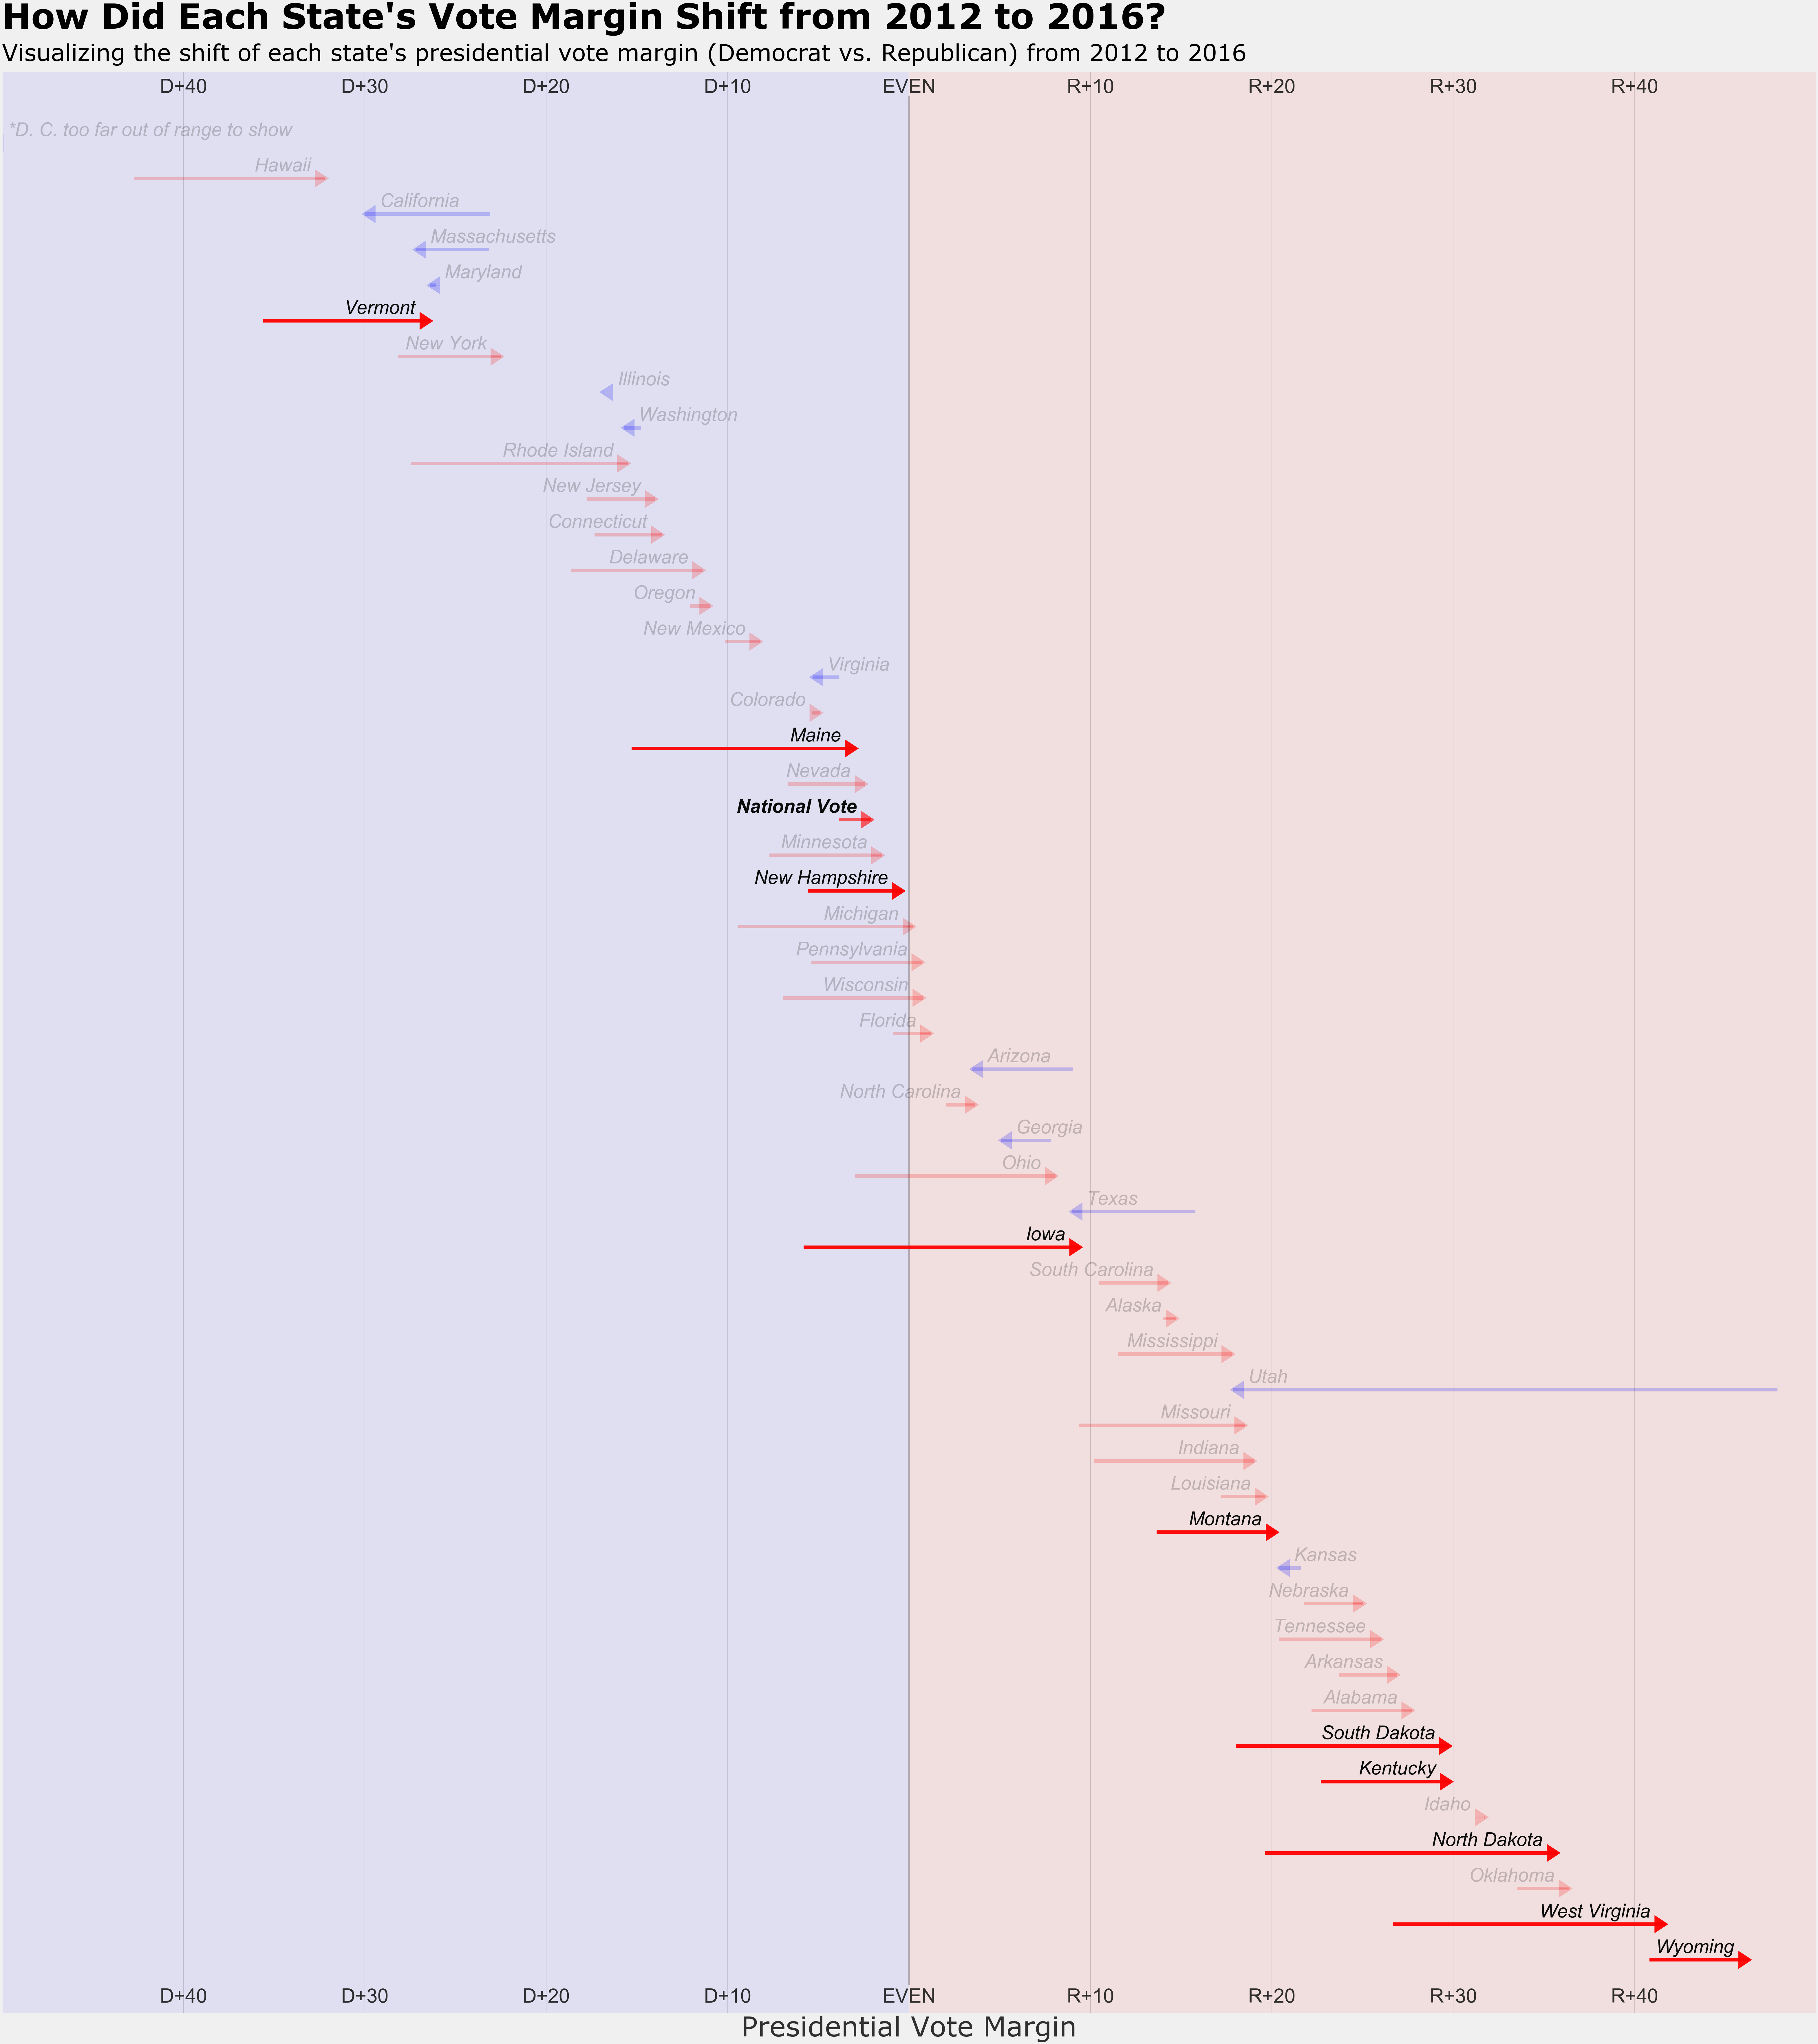

In [17]:
visualize_shifts(new_df_2016, new_df_2012, '2016', '2012', 'margin', highlighted_list)

All 10 top white rural states appear to have shifted at least 6 points to the right in 2016. 6/10 appear to have shifted at least 10 points to the right, a drastic shift for only 4 years.  

It will be interesting to see if the white rural state shift is a relatively new or continuing trend.

Let's see how these states shifted from 2008 to 2012. 

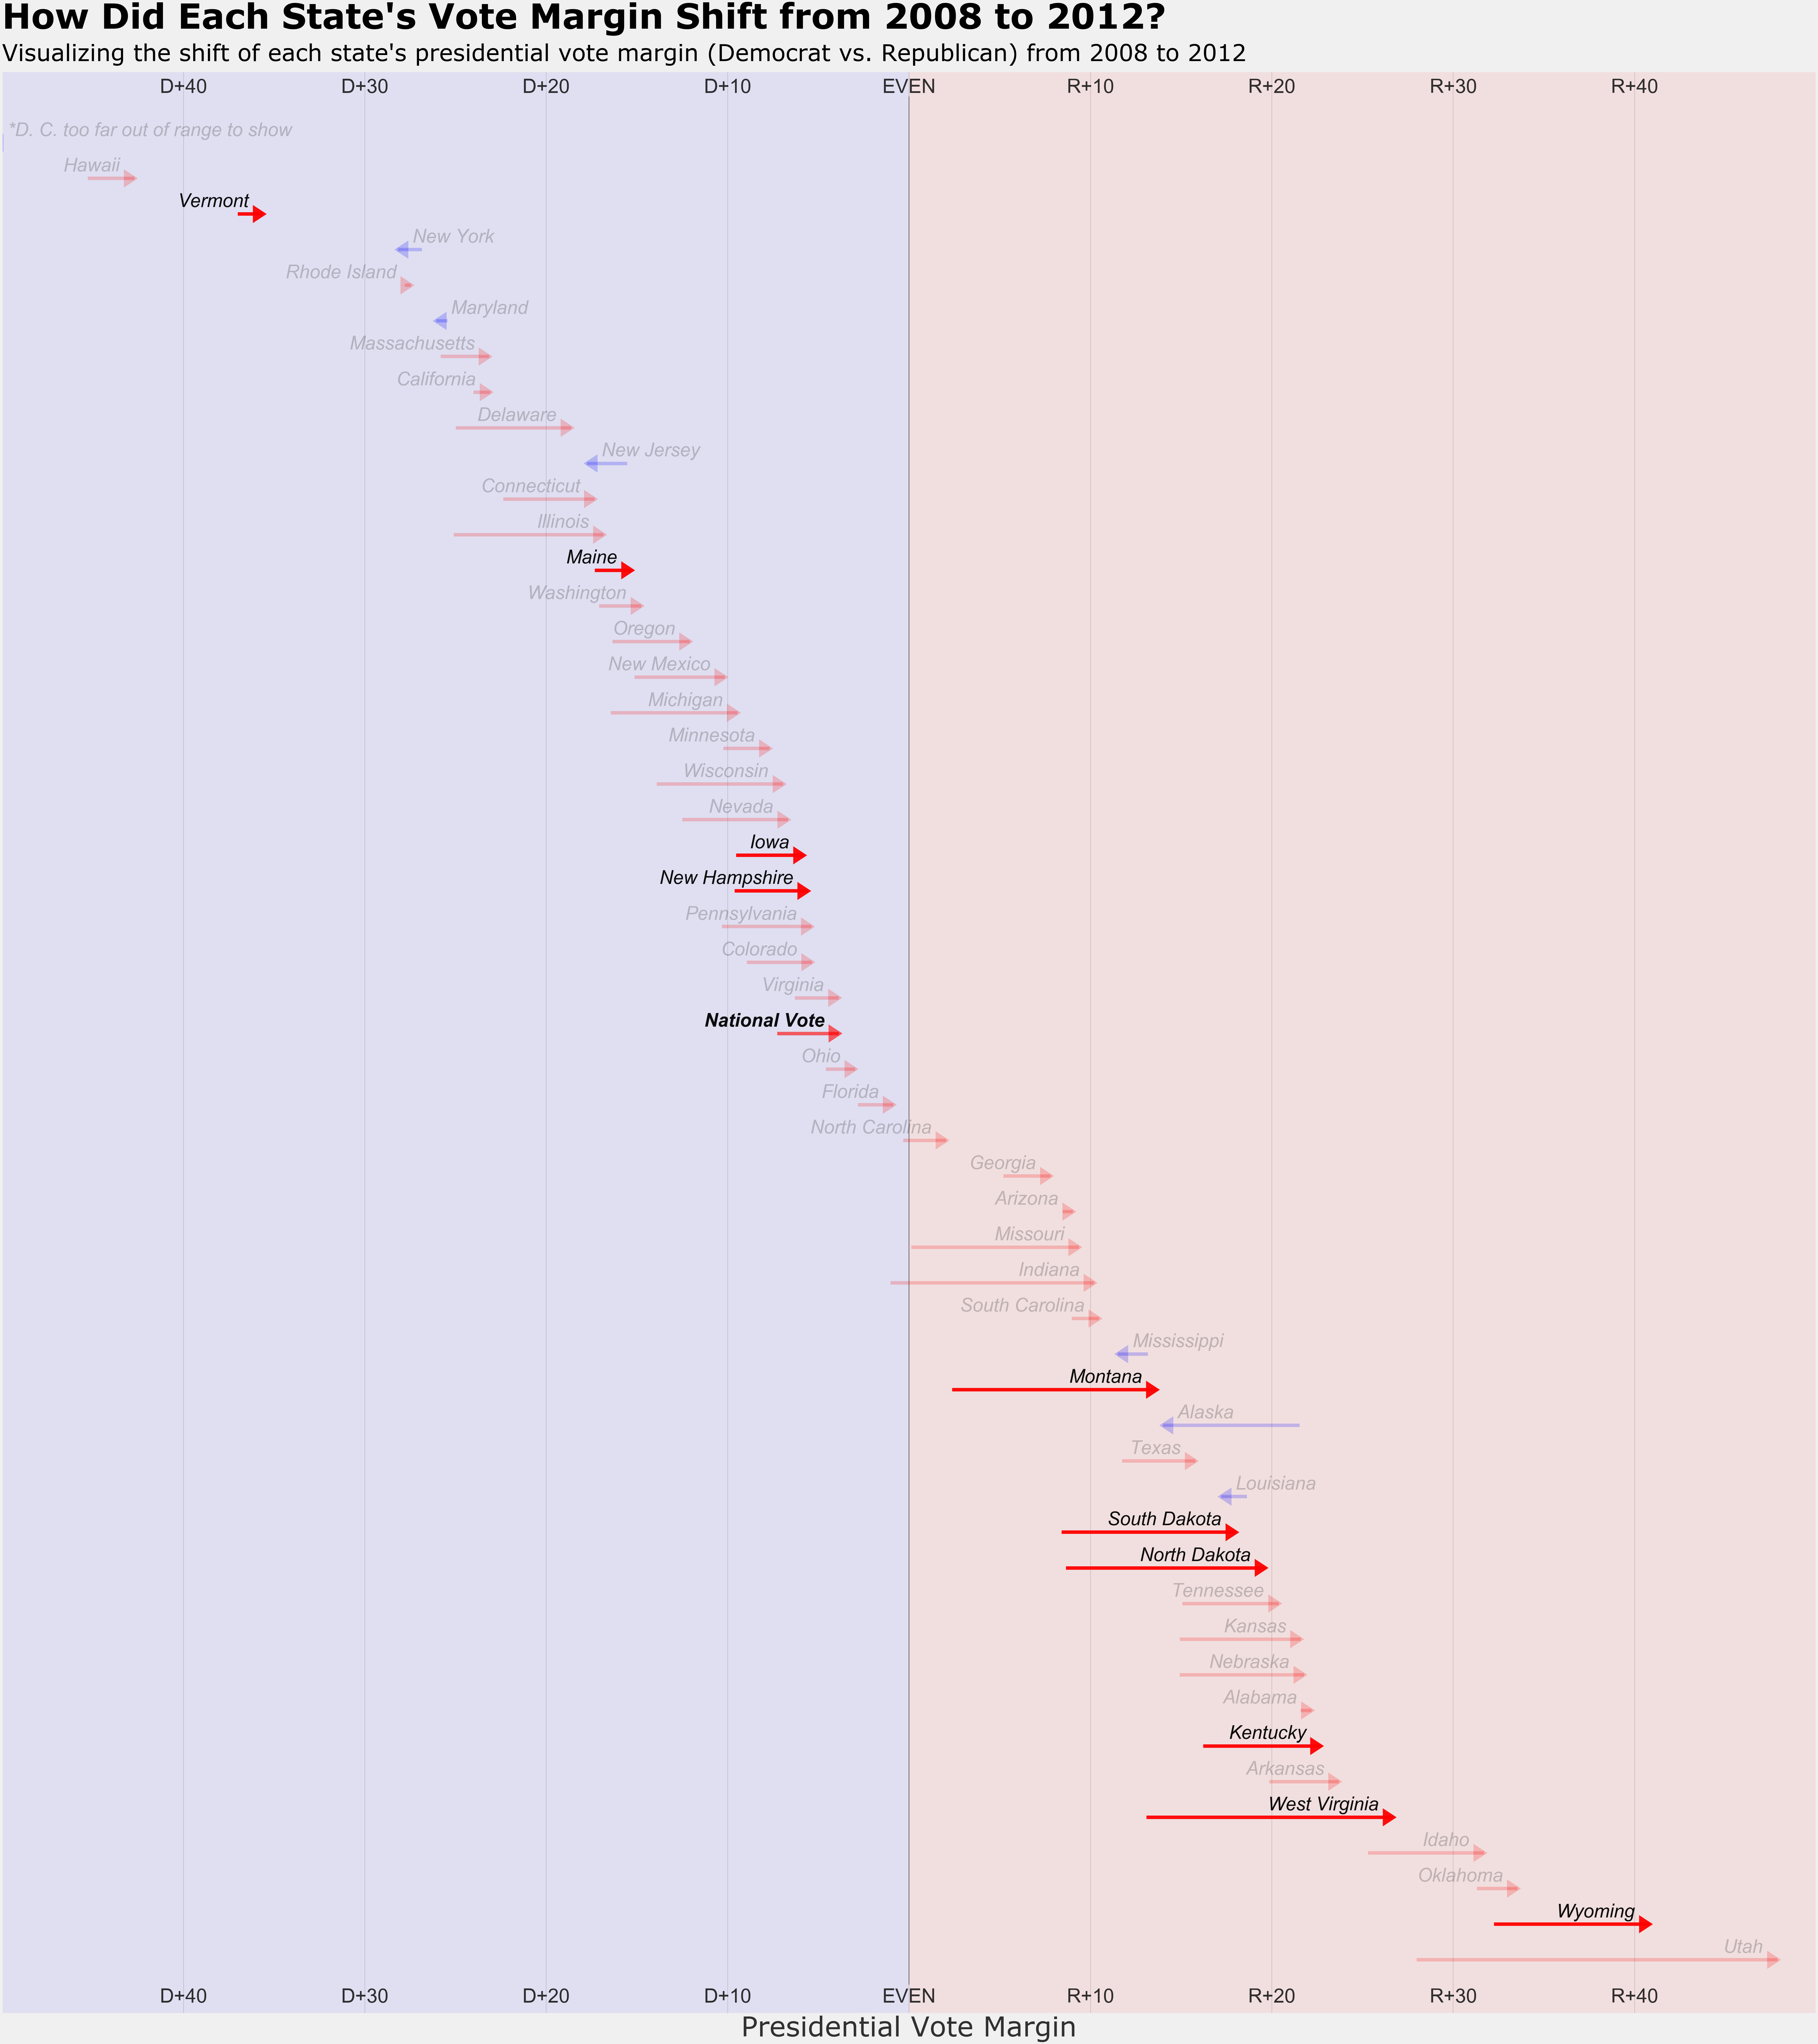

In [18]:
visualize_shifts(new_df_2012, new_df_2008, '2012', '2008', 'margin', highlighted_list)

It appears that white and rural blue states in New England shifted about the same or less than the national vote whereas red states like Montana, South Dakota, North Dakota, and West Virginia shifted drastically to the right in comparison to the national vote in 2008. Let's see how the states shifted from 2004 to 2008 to make a more informed hypothesis, considering Barack Obama was the Democratic candidate in both elections. 

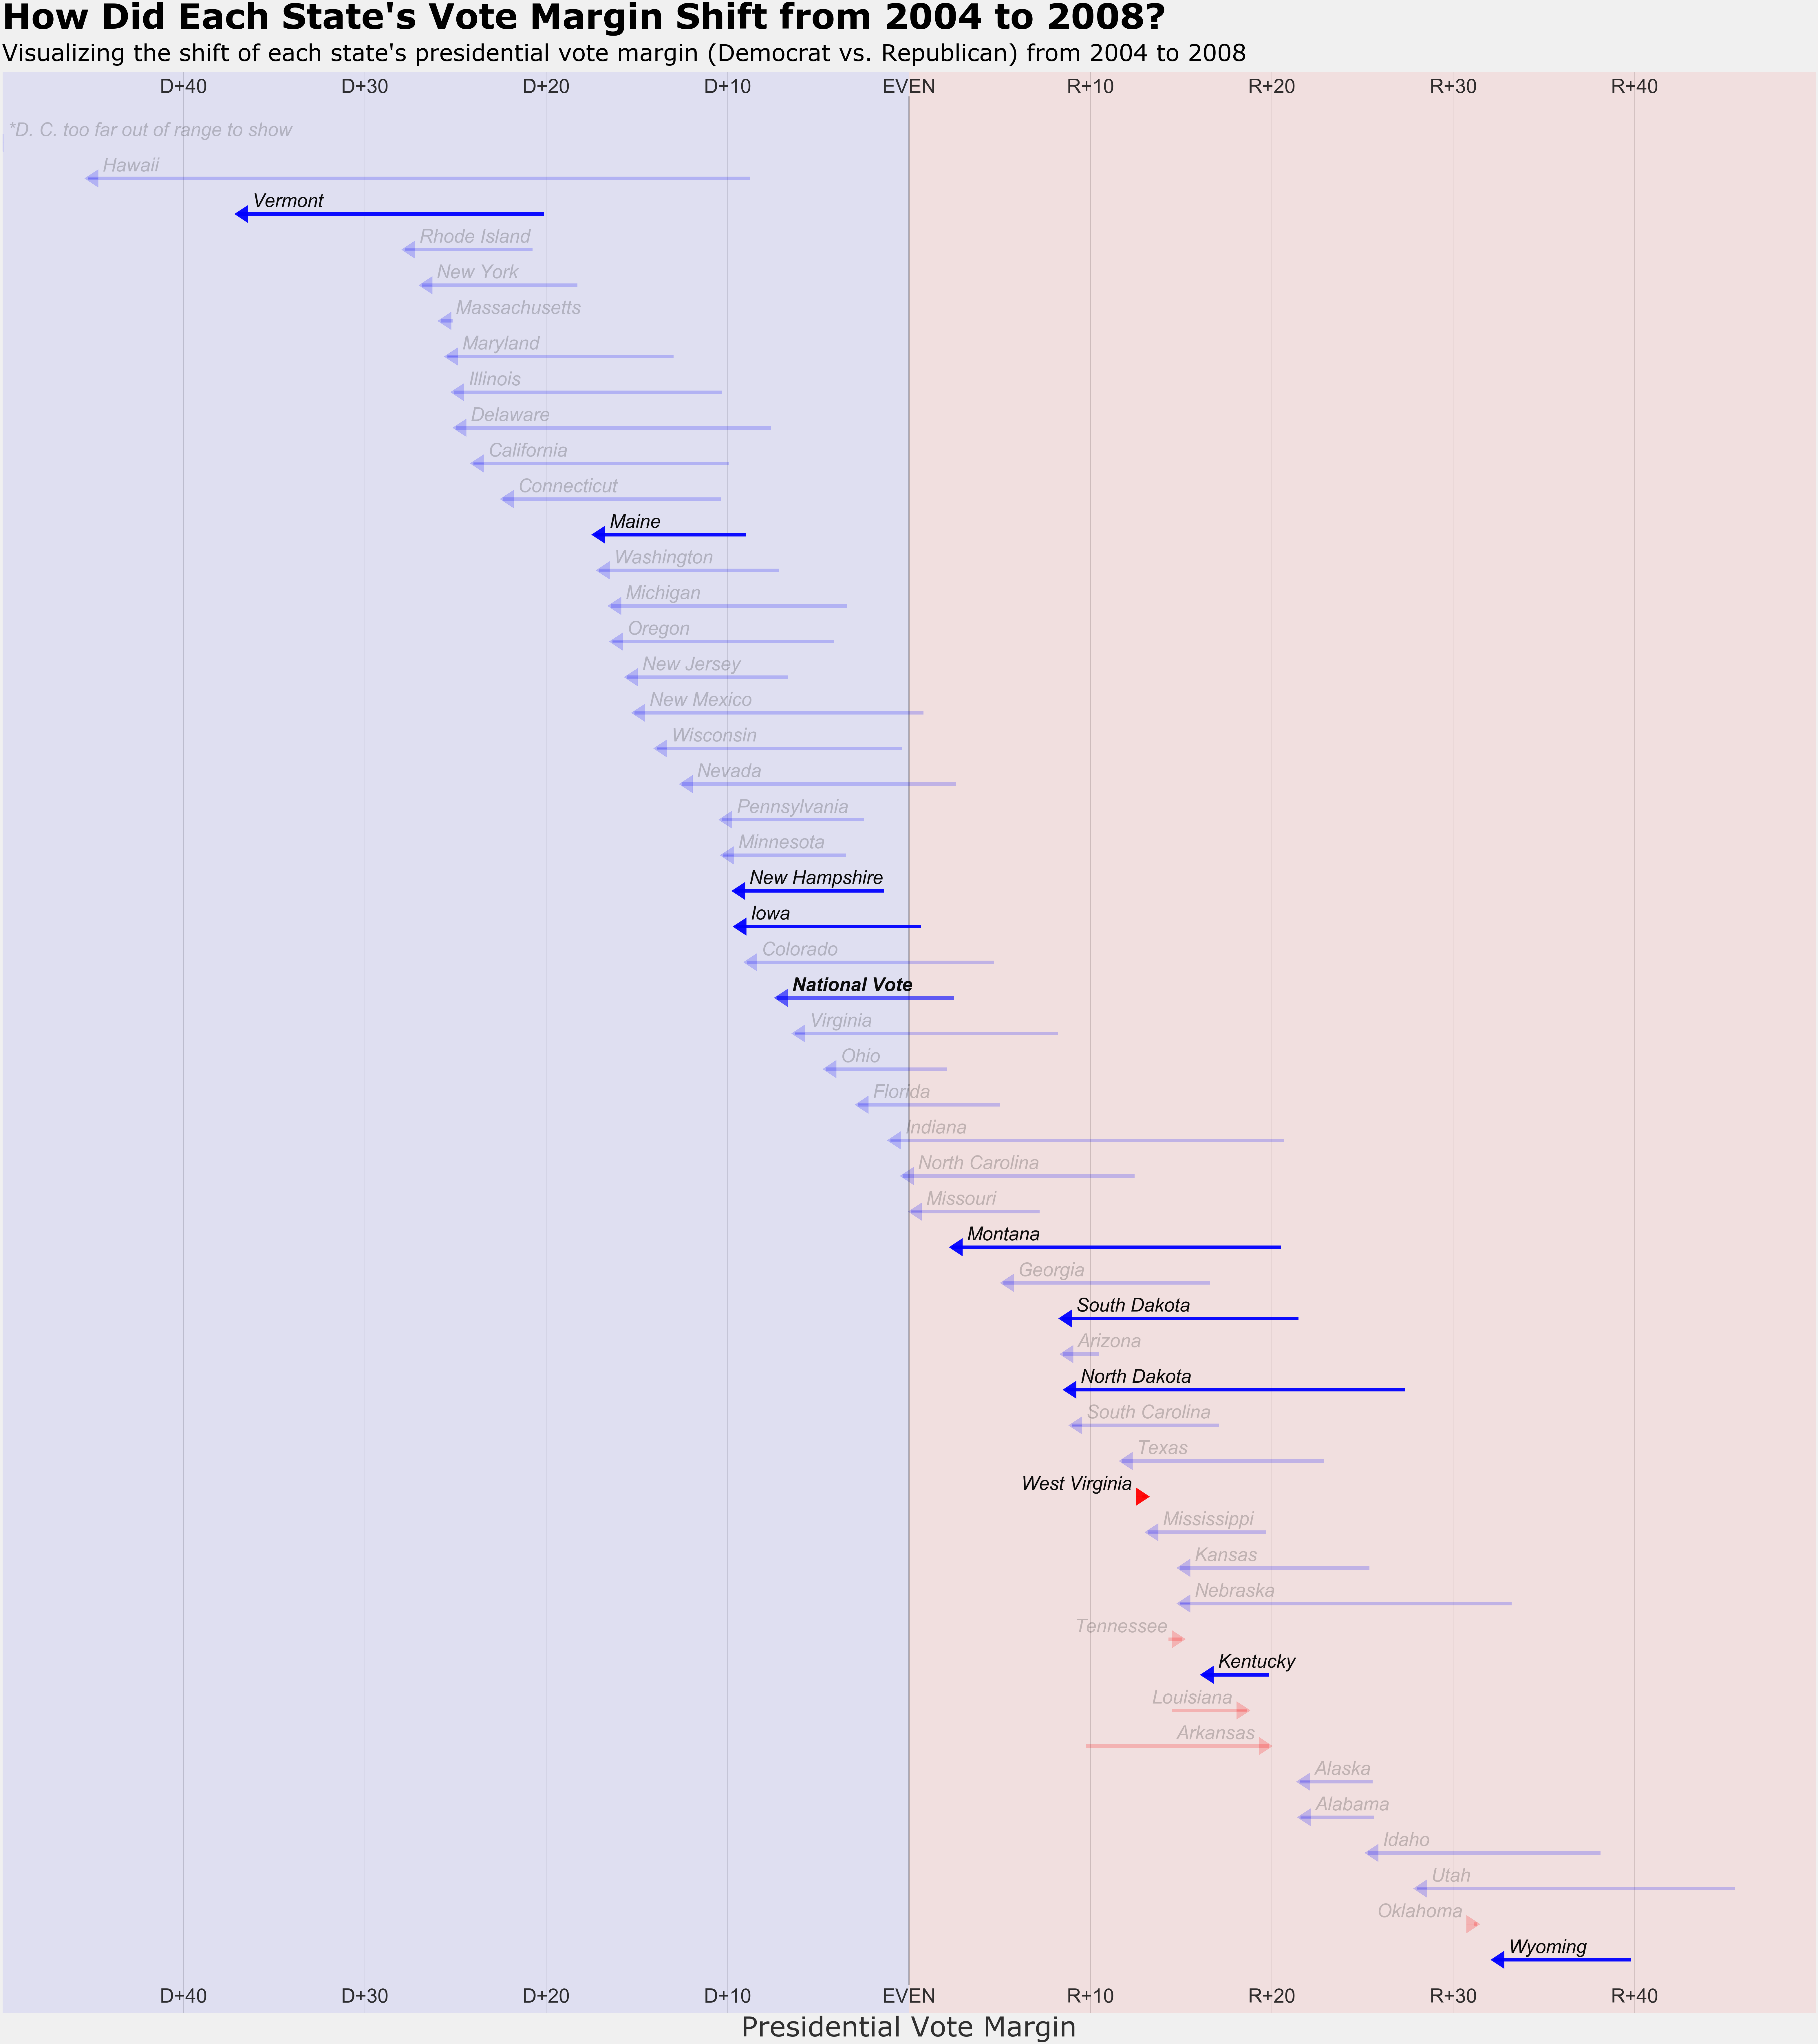

In [19]:
visualize_shifts(new_df_2008, new_df_2004, '2008', '2004', 'margin', highlighted_list)

Here we can see that West Virginia is the only state in this set that been trending red since 2004 (and just barely), with the other 9 states shifting to the left in 2008. Three traditional Republican states in the great plains (Montana, South Dakota, and North Dakota) shifted significantly more to the left than the national vote.

### Summary
* In 2008, white rural states as a whole didn't share much of a pattern in vote shift. White, rural great plains states shifted dramatically farther to the left than the national vote. White, rural coal country (Kentucky and West Virginia) states shifted significantly less than than the rest of the country. 
* In 2012, white rural <i>red states</i> shifted signifcantly more to the right than the national vote whereas traditional blue white rural states pretty much matched the national shift.
* In 2016, all of the most white rural states showed a dramatically larger shift to the right than the national vote.

## Conclusion

Though the media liked to focus on the results in the Rust Belt swing states, these states were just a piece of a larger congolomerate of white rural states which all shifted significantly more to the right than the national vote. In contrast to previous elections, the rural-urban divide and identity politics played an extremely signicant role in the 2016 election and transcended traditonal geographic partisanship.

## Possible Further Steps

* Analyze county vote data to further investigate and visually display the white rural factor 
* Gather detailed economic data from the web and analyze how this impacted vote margins and shifts
* Analyze the most significant correlations in previous elections and compare to 2016
* Investigate the major factors for states that are trending blue 
* Use current trends to predict partisan lean for the 2020 presidential election, as well as subsequent elections
* Visually display vote shifts by state and county on a US map